# Word2Vec

In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [2]:
import multiprocessing
# Paramètres du modèle Word2Vec
w2v_size = 300        # Taille des vecteurs
w2v_window = 5        # Taille de la fenêtre contextuelle
w2v_min_count = 1     # Nombre minimum d'occurrences d'un mot pour être pris en compte
w2v_epochs = 100      # Nombre d'itérations (époques)
workers = multiprocessing.cpu_count()  # Utilisation de tous les cœurs disponibles

### Données

In [9]:
import pandas as pd

train_df = pd.read_csv("./data/train_df.csv")
train_df = train_df.iloc[:, 1:]
test_df = pd.read_csv("./data/test_df.csv")
test_df = test_df.iloc[:, 1:]

### Préparation des sentences

In [4]:
# Préparation des sentences à partir de la colonne 'preprocessed_text'
# Tokenisation de chaque phrase en séparant les mots sur les espaces
train_sentences = [sentence.split() for sentence in train_df['preprocessed_text'].astype(str)]
test_sentences = [sentence.split() for sentence in test_df['preprocessed_text'].astype(str)]

### Modèle Word2Vec

In [5]:
from gensim.models import Word2Vec
# Instanciation du modèle Word2Vec
w2v_model = Word2Vec(
    sentences=train_sentences,   # Les phrases tokenisées d'entraînement
    vector_size=w2v_size,        # Taille des vecteurs
    window=w2v_window,           # Taille de la fenêtre contextuelle
    min_count=w2v_min_count,     # Seuil d'apparition minimum d'un mot
    workers=workers,             # Nombre de threads (CPU cores) à utiliser
    sg=1                         # Utilisation de Skip-gram (si sg=0, on utilise CBOW)
)

In [6]:
# Entraînement du modèle
w2v_model.train(train_sentences, total_examples=len(train_sentences), epochs=w2v_epochs)


(2935618, 3588100)

In [7]:
# Sauvegarde du modèle après entraînement
w2v_model.save("./models/word2vec_model.model")

### Matrice d'embeddings

In [8]:
# Taille du vocabulaire (le nombre de mots uniques)
vocab_size = len(w2v_model.wv.index_to_key)

# Extraction de la matrice d'embedding
embedding_matrix = []
for word in w2v_model.wv.index_to_key:
    embedding_matrix.append(w2v_model.wv[word])

# Conversion en numpy array
import numpy as np
embedding_matrix = np.array(embedding_matrix)

# Dimensions de la matrice d'embedding : vocab_size x w2v_size
print("Matrice d'embedding de taille :", embedding_matrix.shape)

Matrice d'embedding de taille : (6691, 300)


### Modèle d'embedding Keras

Les essais avec un modèle simple (LSTM et dense) ont montré un sur-apprentissage important. Il faut l'optimiser avec dropout, regularisation.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Paramètres
maxlen = 31  # Longueur maximale des séquences de mots
vocab_size = len(w2v_model.wv.index_to_key)  # Taille du vocabulaire

In [10]:
# Instanciation du modèle séquentiel 1
model = Sequential()

# Ajout de la couche d'embedding avec la matrice pré-entraînée
model.add(Embedding(
    input_dim=vocab_size,       # Taille du vocabulaire
    output_dim=w2v_size,        # Dimension des vecteurs d'embedding
    weights=[embedding_matrix], # Utilisation de la matrice d'embedding pré-entraînée
    trainable=False             # Geler les poids de l'embedding
))

# Ajout d'une couche LSTM pour capturer les relations séquentielles
model.add(LSTM(128))

# Ajout d'une couche de sortie (par exemple, pour de la classification binaire)
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,007,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,007,300 (7.66 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,007,300 (7.66 MB)

In [11]:
# Instanciation du modèle séquentiel 2
from tensorflow.keras.regularizers import l2

# Ajout de la régularisation L2 dans la couche LSTM et la couche Dense
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix],
                    trainable=False))
model.add(LSTM(128, kernel_regularizer=l2(0.01)))  # Ajout de la régularisation L2
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # Ajout L2 dans la couche Dense

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Affichage du résumé du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       2,007,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,007,300 (7.66 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,007,300 (7.66 MB)

In [12]:
# Modèle 3 avec dropout

from tensorflow.keras.layers import Dropout

# Ajout de Dropout après la couche LSTM pour prévenir l'overfitting
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix],
                    trainable=False))
model.add(LSTM(128))
model.add(Dropout(0.5))  # Dropout de 50% des neurones
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       2,007,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,007,300 (7.66 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,007,300 (7.66 MB)

In [13]:
# diminuer la complexité LSTM ou utiliser GRU
# Réduction du nombre d'unités dans la couche LSTM
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix],
                    input_length=maxlen, trainable=False))
model.add(LSTM(64))  # Moins d'unités LSTM
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
# Code du modèle avec GRU, Dropout et régularisation L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # Importer Adam pour ajuster le learning rate

# Paramètres de régularisation et Dropout
dropout_rate = 0.5      # Pourcentage de neurones ignorés
l2_lambda = 0.01        # Facteur de régularisation L2
learning_rate = 0.0001  # Taux d'apprentissage spécifique

# Instanciation du modèle séquentiel
model = Sequential()

# 1. Couche d'embedding avec la matrice Word2Vec pré-entraînée
model.add(Embedding(
    input_dim=vocab_size,       # Taille du vocabulaire
    output_dim=w2v_size,        # Dimension des vecteurs d'embedding
    weights=[embedding_matrix], # Matrice d'embedding pré-entraînée
    input_length=maxlen,        # Longueur maximale des séquences
    trainable=False             # Geler les poids de l'embedding
))

# 2. Couche GRU avec Dropout et régularisation L2
model.add(GRU(
    units=128,                    # Nombre d'unités GRU
    kernel_regularizer=l2(l2_lambda),  # Régularisation L2 sur les poids
    recurrent_regularizer=l2(l2_lambda),  # Régularisation L2 sur les poids récurrents
    dropout=dropout_rate,         # Dropout sur les connexions entrantes
    recurrent_dropout=dropout_rate  # Dropout sur les connexions récurrentes
))

# 3. Couche de sortie Dense avec régularisation L2
model.add(Dense(
    units=1,                      # Pour une tâche de classification binaire
    activation='sigmoid',          # Sigmoid pour la probabilité binaire
    kernel_regularizer=l2(l2_lambda)  # Régularisation L2 sur la couche de sortie
))

# Définir l'optimiseur Adam avec un learning rate spécifique
optimizer = Adam(learning_rate=learning_rate)

# Compilation du modèle
model.compile(
    optimizer=optimizer,          # Utiliser l'optimiseur Adam avec le learning rate défini
    loss='binary_crossentropy',   # Fonction de perte pour une classification binaire
    metrics=['accuracy']          # Métrique d'accuracy
)

# Affichage du résumé du modèle
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │       2,007,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,007,300 (7.66 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,007,300 (7.66 MB)

### Préparation des données pour l'exécution du modèle

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Création d'un dictionnaire mot->index à partir du vocabulaire de Word2Vec
word_index = {word: i for i, word in enumerate(w2v_model.wv.index_to_key)}

# Fonction pour convertir les phrases en séquences d'index
def sentences_to_sequences(sentences, word_index):
    sequences = []
    for sentence in sentences:
        seq = [word_index.get(word, 0) for word in sentence]  # Remplacer les mots inconnus par 0
        sequences.append(seq)
    return sequences

# Conversion des phrases d'entraînement et de test en séquences d'index
train_sequences = sentences_to_sequences(train_sentences, word_index)
test_sequences = sentences_to_sequences(test_sentences, word_index)

# Padding des séquences pour qu'elles aient toutes la même longueur (maxlen)
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

# Exemple d'affichage des séquences après padding
print(train_padded[:5])


[[   1   47   31   96   88  101    3 1539 2300 2874  442    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   1  589   82   32   49  161   12   84  353 2299    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [ 332 2298    3   11   68  565  888   78  562  319 2876    0  323   57
  2879    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [ 236  425 2880 2881    6   18   17  977  195   21 2882 2848  545   51
     2    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [ 185  355  317  138  546    2  327  330  706    0  218  705  370   14
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]


### Entrainement du modèle d'embedding

In [16]:
y_train = train_df['target'].values
y_test = test_df['target'].values

# Entraînement du modèle avec validation et sauvegarde de l'historique
history = model.fit(
    train_padded,         # Données d'entraînement
    y_train,              # Étiquettes d'entraînement
    epochs=25,            # Nombre d'époques
    batch_size=32,        # Taille des batchs
    validation_data=(test_padded, y_test),  # Validation sur les données de test
    verbose=1             # Afficher l'évolution pendant l'entraînement
)


Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4925 - loss: 3784969.7500 - val_accuracy: 0.5017 - val_loss: 5.3727
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5498 - loss: 2180576.2500 - val_accuracy: 0.5017 - val_loss: 5.3621
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4997 - loss: 1811297.5000 - val_accuracy: 0.5017 - val_loss: 5.3580
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5164 - loss: 1405651.2500 - val_accuracy: 0.5017 - val_loss: 5.3546
Epoch 5/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5083 - loss: 1162738.3750 - val_accuracy: 0.5017 - val_loss: 5.3476
Epoch 6/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5145 - loss: 973552.3750 - val_accuracy: 0.5017 - val_loss: 5.3433
Epoch 7/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5219 - loss: 820417.3125 - val_accuracy: 0.5017 - val_loss: 5.3398
Epoch 8/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - ac

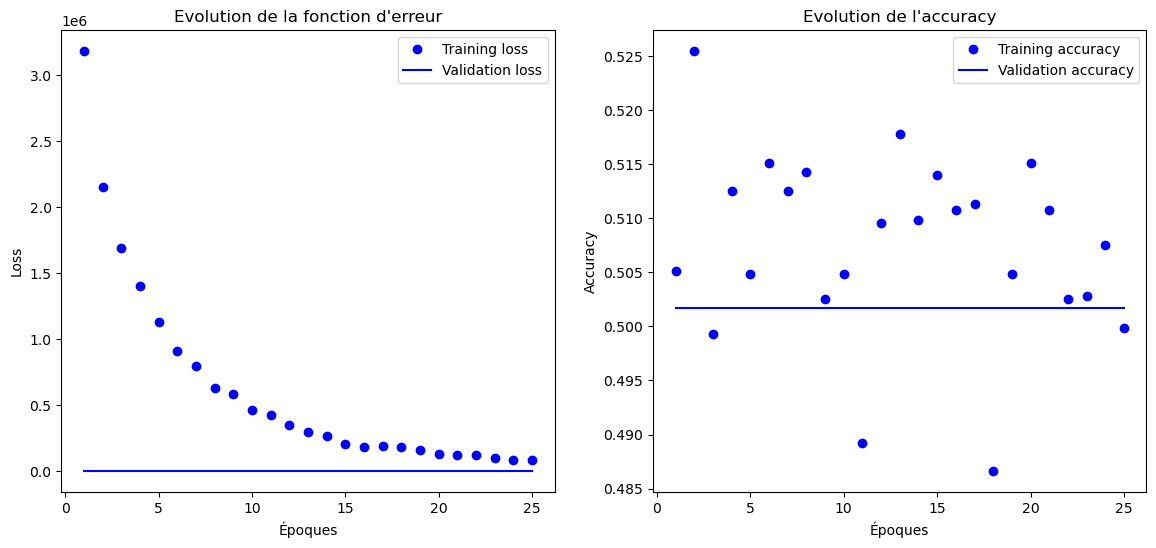

In [17]:
import matplotlib.pyplot as plt

# Récupération de l'historique des erreurs et de l'accuracy
train_loss = history.history['loss']            # Erreur sur l'ensemble d'entraînement
val_loss = history.history['val_loss']          # Erreur sur l'ensemble de validation
train_acc = history.history['accuracy']         # Accuracy sur l'ensemble d'entraînement
val_acc = history.history['val_accuracy']       # Accuracy sur l'ensemble de validation

# Nombre d'époques
epochs = range(1, len(train_loss) + 1)

# Tracer l'évolution de la loss (erreur)
plt.figure(figsize=(14, 6))

# Courbe de la loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Evolution de la fonction d\'erreur')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()

# Courbe de l'accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Evolution de l\'accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Modèle basé sur Bert (pré-entrainé)

In [18]:
# pip install transformers torch

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to preprocess the text and make predictions
def predict_sentiment(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Forward pass, get logits
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted sentiment label
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    # Map the prediction to the sentiment
    sentiment_labels = ['negative', 'neutral', 'positive']
    return sentiment_labels[predicted_class]

# Example usage
text = "I love using the new RoBERTa model for sentiment analysis!"
sentiment = predict_sentiment(text)
print(f"Sentiment: {sentiment}")


C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Sentiment: positive


In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Load the tokenizer and model from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to predict sentiment
def predict_sentiment_roberta(texts):
    # Tokenize the input texts
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Forward pass, get logits
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted class
    logits = outputs.logits
    predicted_classes = torch.argmax(logits, dim=1)
    
    return predicted_classes

# Mapping the RoBERTa outputs to your target classes (0 = positive, 1 = negative)
def map_roberta_to_custom_labels(roberta_prediction):
    # RoBERTa has 3 classes: [negative, neutral, positive]
    # We'll map neutral and negative to 'negative' (1), positive to 'positive' (0)
    return 1 if roberta_prediction in [0, 1] else 0

# Process the DataFrame and predict sentiments for train/test data
def process_and_predict(df):
    predicted_labels = []
    
    for text in df['text']:
        # Predict sentiment for each tweet
        roberta_prediction = predict_sentiment_roberta([text])[0].item()
        
        # Map RoBERTa sentiment to custom labels
        custom_label = map_roberta_to_custom_labels(roberta_prediction)
        predicted_labels.append(custom_label)
    
    return predicted_labels

# Predict on training set
train_predictions = process_and_predict(train_df)
train_labels = train_df['target'].tolist()

# Predict on test set
test_predictions = process_and_predict(test_df)
test_labels = test_df['target'].tolist()

# Evaluate the results
train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

# Classification report for further insights
print("\nClassification Report on Train Data:")
print(classification_report(train_labels, train_predictions, target_names=["positive", "negative"]))

print("\nClassification Report on Test Data:")
print(classification_report(test_labels, test_predictions, target_names=["positive", "negative"]))


C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Train Accuracy:  0.700323815130998
Test Accuracy:  0.7000686341798216

Classification Report on Train Data:
              precision    recall  f1-score   support

    positive       0.78      0.56      0.65      1694
    negative       0.66      0.84      0.74      1703

    accuracy                           0.70      3397
   macro avg       0.72      0.70      0.69      3397
weighted avg       0.72      0.70      0.69      3397


Classification Report on Test Data:
              precision    recall  f1-score   support

    positive       0.77      0.57      0.65       726
    negative       0.66      0.83      0.74       731

    accuracy                           0.70      1457
   macro avg       0.71      0.70      0.69      1457
weighted avg       0.71      0.70      0.69      1457



## Test Roberta tweets sentiment analysis avec fine-tuning

In [1]:
import torch
print("CUDA disponible:", torch.cuda.is_available())  # Devrait retourner True
print("Nom du GPU:", torch.cuda.get_device_name(0))   # Affiche le nom du GPU
print("Version de PyTorch:", torch.__version__)       # Devrait afficher 2.4.1


CUDA disponible: True
Nom du GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Version de PyTorch: 2.4.1+cu118


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load the tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# Freeze all layers except the last classification layer
for param in model.base_model.parameters():
    param.requires_grad = False

# Custom Dataset class to handle tokenization
class TweetDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        target = self.targets[index]
        
        # Tokenization
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [7]:
# Create a DataLoader function
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(
        texts=df['text'].to_numpy(),
        targets=df['target'].to_numpy(),
        tokenizer=tokenizer,
        max_len=maxlen
    )
    
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [10]:
# Sous-échantillonage de train_df 
from sklearn.model_selection import train_test_split

# Taille de l'échantillon (20% du total)
sample_size = 0.2

# Création du sous-échantillon avec stratification sur la colonne 'target'
train_sample, _ = train_test_split(train_df, 
                                   test_size=1 - sample_size, 
                                   stratify=train_df['target'], 
                                   random_state=42)

# Affichage de la répartition des classes dans le sous-échantillon
print(train_sample['target'].value_counts(normalize=True))

target
1    0.500736
0    0.499264
Name: proportion, dtype: float64


In [11]:
from torch.optim import AdamW

# Prepare the data
maxlen = 128  # Adjust according to your data
batch_size = 16  # You can adjust this
train_dataloader = create_data_loader(train_sample, tokenizer, maxlen, batch_size)
test_dataloader = create_data_loader(test_df, tokenizer, maxlen, batch_size)

# Optimizer and learning rate (adjustable)
optimizer = AdamW(model.parameters(), lr=0.0001)

In [12]:
# Training function
def train_epoch(model, dataloader, optimizer, device):
    model = model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=targets
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        total_correct += torch.sum(preds == targets)
        total_samples += targets.size(0)

        loss.backward()
        optimizer.step()

    return total_correct.double() / total_samples, total_loss / total_samples

# Evaluation function
def eval_model(model, dataloader, device):
    model = model.eval()
    total_correct = 0
    total_samples = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            total_correct += torch.sum(preds == targets)
            total_samples += targets.size(0)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    accuracy = total_correct.double() / total_samples
    return accuracy, predictions, true_labels

In [16]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
epochs = 1  # Adjust as necessary

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_dataloader, optimizer, device)
    print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

In [ ]:
# Evaluate the model on the test set
test_acc, test_preds, test_true = eval_model(model, test_dataloader, device)
print(f'Test Accuracy: {test_acc:.4f}')

# Classification report
print("\nClassification Report on Test Data:")
print(classification_report(test_true, test_preds, target_names=["positive", "negative"]))

C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
